# Image Based Fashion Product Recommendation with Deep Learning and Graph-based Attention


# Introduction

Dans ce notebook, je vais utiliser un modèle CNN pour créer un **Fashion Embedding**. Ces informations pourront être utilisées dans des algorithmes de machine learning avec une meilleure qualité sémantique et une similitude accrue entre les objets. Nous utiliserons les embeddings pour identifier des articles similaires, et ces informations seront utilisées pour recommander du contenu similaire dans un système de recommandation.

# Préparation des données

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['images.csv', 'images', 'styles.csv', 'styles']


In [3]:
df = pd.read_csv(DATASET_PATH + "styles.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [4]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

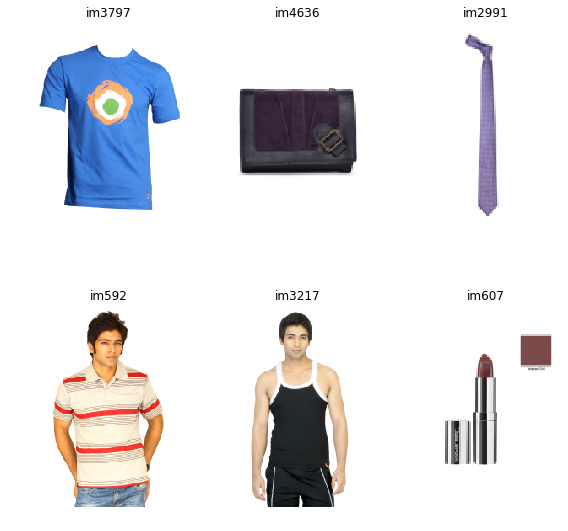

In [9]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Système de Recommandation Basé sur la Popularité

In [6]:
# Generate random ratings for products
np.random.seed(42)  # for reproducibility
df['rating'] = np.random.uniform(1, 5, size=len(df)).round(2)
df['num_ratings'] = np.random.randint(10, 1000, size=len(df))

In [7]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,rating,num_ratings
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,2.50,659
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,4.80,618
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,3.93,621
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,3.39,794
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,1.62,250


In [8]:
# Popularity-based Recommender System
class PopularityRecommender:
    def __init__(self, dataframe):
        
        self.df = dataframe
    
    def get_top_products(self, category=None, n=10):
        
        # Create a popularity score based on rating and number of ratings
        df_filtered = self.df.copy()
        
        if category:
            df_filtered = df_filtered[df_filtered['masterCategory'] == category]
        
        # Calculate popularity score
        df_filtered['popularity_score'] = (
            df_filtered['rating'] * df_filtered['num_ratings']
        )
        
        # Sort and return top N products
        top_products = df_filtered.nlargest(n, 'popularity_score')
        
        return top_products[['id', 'productDisplayName', 'masterCategory', 'rating', 'num_ratings', 'popularity_score']]


In [9]:
# Initialize recommender
recommender = PopularityRecommender(df)

print("Top 10 Products Overall:")
recommender.get_top_products()

Top 10 Products Overall:


,id,productDisplayName,masterCategory,rating,num_ratings,popularity_score
28808,25839,Diva Women Printed Red Kurta,Apparel,4.98,999,4975.02
36998,11417,United Colors of Benetton Men Light Winter Blu...,Apparel,5.00,994,4970.00
32964,20387,Baggit Women Bunny Taj Purple Handbag,Accessories,4.98,995,4955.10
17367,50990,Enamor Women Red Briefs,Apparel,4.97,995,4945.15
1277,4344,Fila Men's Abascuss White Blue Shoe,Footwear,4.95,998,4940.10
4035,13615,Hanes Men Grey V DuoDry Body Fit V-Neck T-shirt,Apparel,4.95,998,4940.10
22591,9854,Indian Terrain Men Laffer Black Trousers,Apparel,4.98,991,4935.18
31986,53811,Ayaany Women Printed White Tunic,Apparel,4.96,993,4925.28
6778,26044,John Miller Men Pink Shirt,Apparel,4.96,992,4920.32
36030,27315,ADIDAS Women Natural Vitality Pack of 2 Fragra...,Personal Care,4.97,990,4920.30


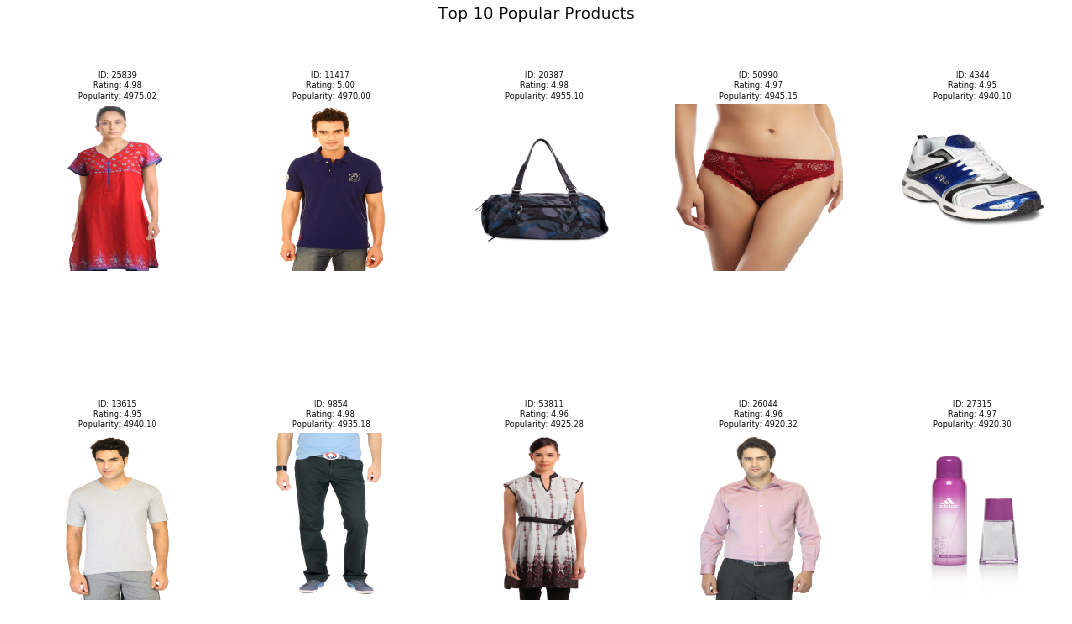

In [10]:
def plot_recommended_products(recommender, category=None, n=10, figsize=(15, 10)):
    # Get top products
    top_products = recommender.get_top_products(category, n)
    
    # Calculate grid dimensions
    num_products = len(top_products)
    ncols = min(5, num_products)  # Max 5 columns
    nrows = (num_products + ncols - 1) // ncols  # Ceiling division
    
    # Create figure and subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(f'Top {n} Popular Products' + 
                 (f' in {category} Category' if category else ''), 
                 fontsize=16)
    
    # Flatten axs if it's a 2D array
    axs = axs.flatten() if num_products > 1 else [axs]
    
    # Plot each product
    for i, (_, row) in enumerate(top_products.iterrows()):
        try:
            # Load and display image
            img_path_full = DATASET_PATH + "/images/" + str(row['id']) + ".jpg"
            img = cv2.imread(img_path_full)
            
            if img is not None:
                # Convert BGR to RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Resize image to have a consistent display
                img_resized = cv2.resize(img_rgb, (200, 200), interpolation=cv2.INTER_AREA)
                
                axs[i].imshow(img_resized)
                axs[i].axis('off')
                
                # Add product details as title
                title = f"ID: {row['id']}\nRating: {row['rating']:.2f}\nPopularity: {row['popularity_score']:.2f}"
                axs[i].set_title(title, fontsize=8)
            else:
                print(f"Could not load image for product {row['id']}")
        
        except Exception as e:
            print(f"Error processing product {row['id']}: {e}")
    
    # Hide any unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_recommended_products(recommender)

# Visualisation de distribution

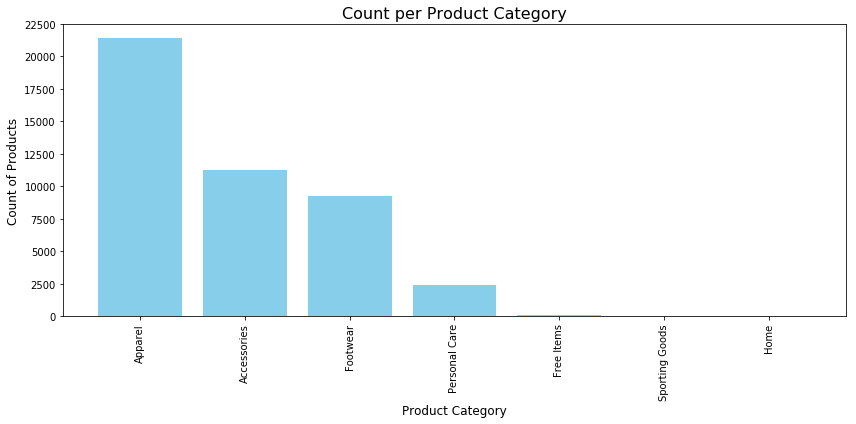

In [11]:
# Group the data by 'masterCategory' and count the 'id'
category_counts = df.groupby('masterCategory')['id'].count().reset_index()

# Sort the values in descending order by count
category_counts = category_counts.sort_values(by='id', ascending=False)

# Create a bar plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(category_counts['masterCategory'], category_counts['id'], color='skyblue')

# Add titles and labels
plt.title('Count per Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Count of Products', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

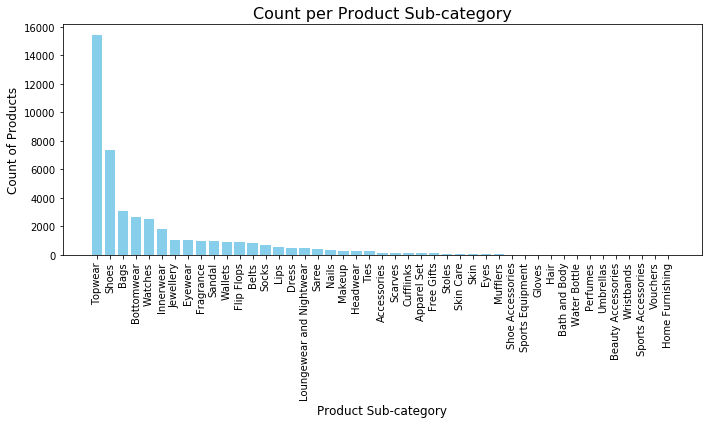

In [12]:
# Group the data by 'subCategory' and count the 'id'
category_counts = df.groupby('subCategory')['id'].count().reset_index()

# Sort the values in descending order by count
category_counts = category_counts.sort_values(by='id', ascending=False)

# Create a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(category_counts['subCategory'], category_counts['id'], color='skyblue')

# Add titles and labels
plt.title('Count per Product Sub-category', fontsize=16)
plt.xlabel('Product Sub-category', fontsize=12)
plt.ylabel('Count of Products', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

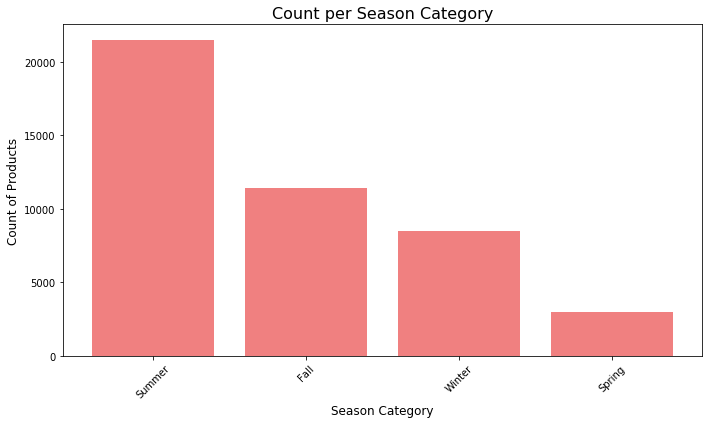

In [13]:
# Group the data by 'season' and count the 'id'
season_counts = df.groupby('season')['id'].count().reset_index()

# Sort the values in descending order by count
season_counts = season_counts.sort_values(by='id', ascending=False)

# Create a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(season_counts['season'], season_counts['id'], color='lightcoral')

# Add titles and labels
plt.title('Count per Season Category', fontsize=16)
plt.xlabel('Season Category', fontsize=12)
plt.ylabel('Count of Products', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

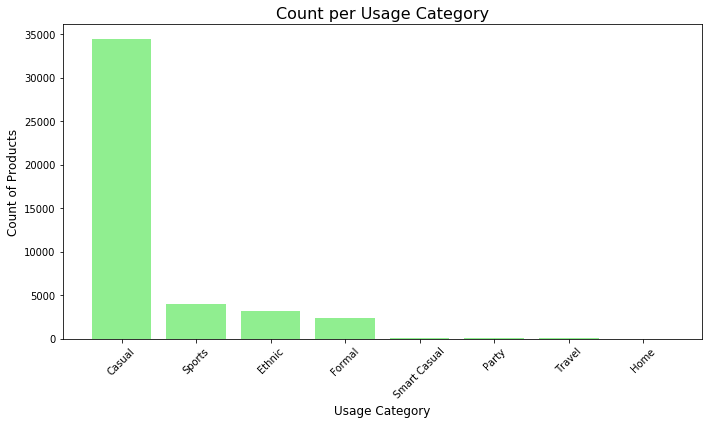

In [14]:
# Group the data by 'usage' and count the 'id'
usage_counts = df.groupby('usage')['id'].count().reset_index()

# Sort the values in descending order by count
usage_counts = usage_counts.sort_values(by='id', ascending=False)

# Create a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(usage_counts['usage'], usage_counts['id'], color='lightgreen')

# Add titles and labels
plt.title('Count per Usage Category', fontsize=16)
plt.xlabel('Usage Category', fontsize=12)
plt.ylabel('Count of Products', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Utiliser un Modèle Pré-entrainé pour la Recommandation

In [15]:
!pip install tensorflow==2.6.2

     |████████████████████████████████| 458.3MB 79kB/s s eta 0:00:01    |██████▎                         | 89.5MB 53.7MB/s eta 0:00:07     |████████████████████▏           | 288.7MB 49.2MB/s eta 0:00:04
     |████████████████████████████████| 22.0MB 36.6MB/s eta 0:00:01
     |████████████████████████████████| 133kB 34.1MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 32.3MB/s eta 0:00:01
     |████████████████████████████████| 71kB 23.6MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 33.6MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 37.0MB/s eta 0:00:01
     |████████████████████████████████| 471kB 45.2MB/s eta 0:00:01
     |████████████████████████████████| 4.0MB 27.2MB/s eta 0:00:01
     |████████████████████████████████| 163kB 32.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 19.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 17.1MB/s eta 0:00:01
     |████████████████████████████████| 4.9MB 33.9MB/s eta 0:

In [16]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications import ResNet50  # For TensorFlow 2.x
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
tf.__version__

'2.6.2'

In [17]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [41]:
def get_embedding(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [42]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(108,)

(240, 180, 3)
[2.1045285e-10 3.7194695e-08 2.2367279e-10 2.7170350e-09 1.7105161e-06
 1.7367370e-10 3.1012738e-11 6.0045318e-04 4.0562409e-08 2.1949305e-10
 1.2180345e-08 1.7285645e-06 4.0360634e-10 1.9978162e-07 4.4506981e-11
 6.2814637e-10 1.0440840e-08 7.3329692e-10 3.3781347e-10 1.7954832e-10
 2.8415950e-06 2.0538801e-10 2.7207668e-07 1.5111917e-08 6.8284657e-12
 7.1922611e-14 2.1298662e-08 4.0351705e-10 7.8652523e-10 8.1831644e-08
 7.9858874e-05 7.9582507e-11 4.2935161e-10 2.3562647e-09 1.5770862e-05
 7.8503989e-14 7.2137080e-10 2.3669096e-12 1.1861253e-08 9.8757894e-08
 1.2088876e-06 2.5615559e-03 1.8111116e-07 6.1787881e-09 3.4037374e-08
 1.5960436e-10 9.8215949e-08 1.0602970e-05 3.6071364e-05 9.0496783e-09
 5.5638986e-07 3.7819571e-08 2.7048683e-09 1.0690506e-10 2.3919659e-08
 5.4733302e-09 3.6854347e-10 1.1600159e-07 7.3938633e-11 1.6247629e-13
 4.7077095e-12 1.3093687e-10 8.2179374e-11 4.1427231e-09 4.1755788e-10
 1.7334503e-05 1.5502749e-08 2.9873247e-13 5.5737687e-10 2.6595

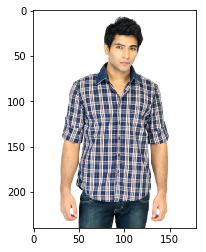

In [43]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [44]:
df.shape

(5000, 14)

In [45]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

CPU times: user 35min 29s, sys: 1min 3s, total: 36min 32s
Wall time: 15min 50s


# Évaluation de la Performance du Modèle ResNet50


In [3]:
EMBS_PATH = "/kaggle/input/finaldataset/"
# Load pre-computed embeddings
df_embs = pd.read_csv(EMBS_PATH + "embeddings.csv")
df_embs = df_embs.iloc[:, 1:]  # Remove index column if present
df_embs

,1,2,3,4,5,6,7,8,9,10,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.366158,0.000000,3.255738,0.845206,2.673840,8.780885,6.280785,0.787186,1.587662,4.747005,...,2.463607,0.000000,1.825990,20.485271,3.902871,0.000000,8.225971,1.313863,0.000000,10.820534
1,9.593652,0.000000,9.431687,0.287238,0.259950,17.028755,3.037456,0.136339,0.000000,1.965363,...,1.670569,0.013894,10.338678,4.784732,0.189142,0.000000,7.739138,0.372693,0.000000,8.903797
2,3.162264,0.484694,0.172313,2.609545,3.840852,3.426132,0.253247,1.098901,1.418278,4.961284,...,0.434923,14.092848,3.018758,2.134510,2.549057,0.377387,6.180353,0.636621,14.018168,11.415053
3,1.958622,0.000000,12.519884,0.000000,0.000000,9.383584,3.781623,0.000000,1.490620,1.974221,...,17.825481,0.000000,3.592511,2.042306,0.000000,0.000000,6.656784,1.457313,1.694215,1.403331
4,17.383436,0.493822,3.374463,2.567366,0.000000,6.482548,5.862635,0.000000,3.164864,2.575928,...,4.464021,0.447082,1.448132,12.884141,0.000000,0.397488,5.028076,1.939697,0.000000,11.485396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,1.086933,10.603666,0.000000,0.899589,4.906456,4.040016,3.416561,0.000000,0.000000,13.161461,...,0.000000,0.000000,7.320971,0.000000,9.822886,4.144007,6.952935,0.000000,0.020810,4.872601
44420,0.745805,2.542379,4.390184,0.557589,8.990882,23.827869,0.624198,0.000000,2.196723,16.549940,...,16.779911,5.880525,5.349078,0.000000,1.521402,9.757891,8.682236,8.933413,3.940487,3.360285
44421,17.258789,1.072109,2.708099,0.259384,0.000000,4.596123,4.987752,3.391690,0.304968,0.000000,...,5.246232,2.968144,1.390609,18.857891,0.000000,0.000000,3.451751,5.321138,0.000000,13.287771
44422,0.416820,0.440426,0.014159,12.214248,3.102999,1.316717,1.407639,0.000000,0.000000,1.542082,...,2.067938,8.295972,3.333411,2.257573,3.544628,0.000000,4.615053,4.111631,11.224733,5.817847


In [19]:
X = np.array(df_embs)
X = np.where(np.isnan(X), 0.0, X)        # Remplacer NaN par 0
X = np.where(np.isposinf(X), 1.0, X)     # Remplacer +inf par 1
X = np.where(np.isneginf(X), -1.0, X)    # Remplacer -inf par -1

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['articleType']) 
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Get the number of features (embedding dimension)
embedding_dim = X.shape[1]
num_classes = len(label_encoder.classes_)

# rchitecture du modèle
model = Sequential([
    Input(shape=(embedding_dim,)),
    Dense(256, activation='relu'),  # Augmenter les neurones
    BatchNormalization(),           # Ajout de BatchNormalization pour stabiliser l'entraînement
    Dropout(0.5),                   # Régularisation pour éviter le surapprentissage
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Couche de sortie pour la classification
])

# Compiler le modèle avec un taux d'apprentissage réduit
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  # Arrêter si aucune amélioration sur 5 epochs
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5,  # Divise le taux d'apprentissage par 2 si la validation ne s'améliore pas
                              patience=3,  # Après 3 epochs sans amélioration
                              min_lr=1e-6)  # Taux d'apprentissage minimum

# Entraînement avec les callbacks
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # Plus d'epochs pour utiliser EarlyStopping
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1111/1111 [==============================] - 7s 5ms/step - loss: 4.5506 - accuracy: 0.1136 - val_loss: 3.2344 - val_accuracy: 0.4814
Epoch 2/100
1111/1111 [==============================] - 5s 5ms/step - loss: 3.2561 - accuracy: 0.3920 - val_loss: 2.4151 - val_accuracy: 0.6021
Epoch 3/100
1111/1111 [==============================] - 5s 5ms/step - loss: 2.6201 - accuracy: 0.5232 - val_loss: 1.9781 - val_accuracy: 0.6555
Epoch 4/100
1111/1111 [==============================] - 5s 5ms/step - loss: 2.2313 - accuracy: 0.5862 - val_loss: 1.7023 - val_accuracy: 0.6835
Epoch 5/100
1111/1111 [==============================] - 5s 5ms/step - loss: 1.9715 - accuracy: 0.6247 - val_loss: 1.5047 - val_accuracy: 0.7039
Epoch 6/100
1111/1111 [==============================] - 5s 5ms/step - loss: 1.7720 - accuracy: 0.6516 - val_loss: 1.3621 - val_accuracy: 0.7184
Epoch 7/100
1111/1111 [==============================] - 5s 5ms/step - loss: 1.6271 - accuracy: 0.6702 - val_loss: 1.2497 - val_ac

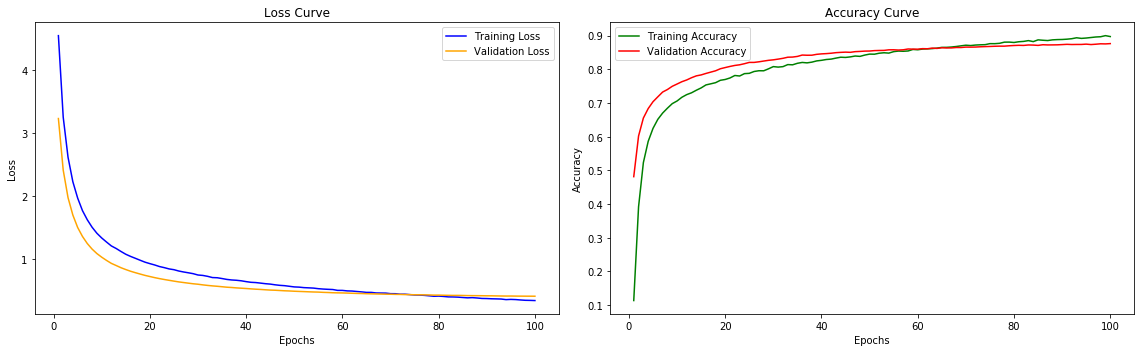

In [28]:
# Tracer les courbes d'apprentissage
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Loss
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction
plot_learning_curves(history)

In [29]:
# Ignorer les warnings
warnings.filterwarnings('ignore')

# Prédictions sur l'ensemble de test
y_pred = np.argmax(model.predict(X_test), axis=1)  # Classes prédites
y_true = np.argmax(y_test, axis=1)                 # Classes réelles

# Calcul des métriques globales pondérées
precision = precision_score(y_true, y_pred, average='weighted')  # Précision pondérée
recall = recall_score(y_true, y_pred, average='weighted')        # Rappel pondéré
f1 = f1_score(y_true, y_pred, average='weighted')                # F1-score pondéré

# Afficher les métriques globales
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8626
Recall: 0.8764
F1-score: 0.8648


In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

278/278 [==============================] - 1s 2ms/step - loss: 0.4128 - accuracy: 0.8764
Loss: 0.4128, Accuracy: 0.8764


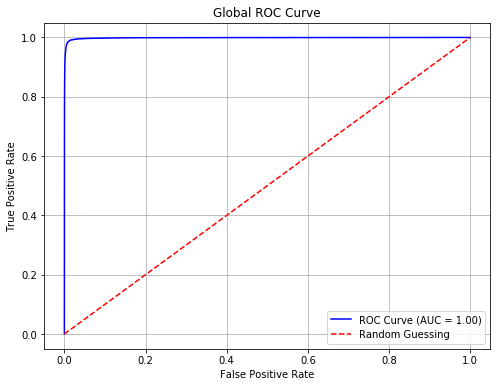

In [31]:
# Binariser les étiquettes réelles pour les classes
y_true = np.argmax(y_test, axis=1)  # Classes réelles
y_pred = model.predict(X_test)     # Prédictions (probabilités pour chaque classe)

# Binariser les étiquettes
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Calculer la courbe ROC globale (micro-average)
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC globale
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Global ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Système de Recommandation avec Similarité :

In [5]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows= 5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
4995,44573,Men,Footwear,Sandal,Sandals,Brown,Summer,2012,Casual,Coolers Men Brown Sandals,44573.jpg
4996,37081,Women,Accessories,Bags,Handbags,Brown,Summer,2012,Casual,Lino Perros Women Brown Handbag,37081.jpg
4997,57958,Women,Apparel,Saree,Sarees,Green,Summer,2012,Ethnic,Prafful Green Printed Sari,57958.jpg
4998,5654,Men,Footwear,Shoes,Sports Shoes,White,Summer,2011,Sports,Reebok Men's Winning Stride White Shoe,5654.jpg


In [14]:
EMBS_PATH = "/kaggle/input/datasetemb/"
# Load pre-computed embeddings
df_embs = pd.read_csv(EMBS_PATH + "embeddings (1).csv")
df_embs = df_embs.iloc[:, 1:]  # Remove index column if present

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

def compute_multi_metric_similarity(embeddings_a, embeddings_b):
    """
    Calcule la similarité en utilisant plusieurs métriques avec un meilleur équilibrage
    """
    # Similarité cosinus
    cosine_sim = cosine_similarity(embeddings_a, embeddings_b)
    
    # Distance euclidienne normalisée
    euclidean_dist = euclidean_distances(embeddings_a, embeddings_b)
    scaler = MinMaxScaler()
    euclidean_sim = 1 - scaler.fit_transform(euclidean_dist)
    
    # Combinaison avec plus de poids sur la similarité cosinus
    combined_sim = 0.8 * cosine_sim + 0.2 * euclidean_sim
    
    return combined_sim

def build_enhanced_graph(df_embs, min_threshold=0.90, max_neighbors=10):
    """
    Construction d'un graphe avec un seuil de similarité plus strict
    """
    G = nx.Graph()
    num_items = len(df_embs)
    
    # Calcul des similarités multi-métriques
    similarities = compute_multi_metric_similarity(df_embs, df_embs)
    
    # Normalisation plus agressive des similarités
    similarities = np.power(similarities, 2)  # Accentue les différences
    
    for i in range(num_items):
        G.add_node(i)
        
        # Sélection plus stricte des voisins
        sim_scores = similarities[i]
        potential_neighbors = np.where(sim_scores > min_threshold)[0]
        potential_neighbors = potential_neighbors[potential_neighbors != i]
        
        if len(potential_neighbors) > max_neighbors:
            top_neighbors = potential_neighbors[np.argsort(sim_scores[potential_neighbors])[-max_neighbors:]]
        else:
            top_neighbors = potential_neighbors
            
        for j in top_neighbors:
            G.add_edge(i, j, weight=similarities[i, j])
    
    return G, similarities

def compute_enhanced_attention(graph, embeddings, similarities, temperature=0.5):
    """
    Calcul d'attention avec température plus basse pour plus de sélectivité
    """
    attention_weights = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
            
        neighbor_similarities = similarities[node, neighbors]
        attention_scores = np.exp(neighbor_similarities / temperature)
        attention_weights[node] = attention_scores / np.sum(attention_scores)
    
    return attention_weights

def find_enhanced_similar_items(target_idx, embeddings, similarities, top_n=8, similarity_threshold=0.85):
    """
    Recherche d'articles similaires avec filtrage strict et vérification de cohérence
    """
    initial_similarities = similarities[target_idx]
    
    # Filtrage strict des candidats
    valid_candidates = np.where(initial_similarities > similarity_threshold)[0]
    valid_candidates = valid_candidates[valid_candidates != target_idx]
    
    if len(valid_candidates) == 0:
        return np.array([]), np.array([])
    
    # Calcul de la cohérence entre les candidats
    candidate_similarities = similarities[valid_candidates][:, valid_candidates]
    coherence_scores = np.mean(candidate_similarities, axis=1)
    
    # Score final combinant similarité et cohérence
    final_scores = 0.7 * initial_similarities[valid_candidates] + 0.3 * coherence_scores
    
    # Sélection des meilleurs candidats
    top_indices = np.argsort(final_scores)[::-1][:top_n]
    selected_items = valid_candidates[top_indices]
    selected_weights = initial_similarities[selected_items]
    
    return selected_items, selected_weights

def run_enhanced_recommendation_pipeline(df_embs, target_idx, top_n=8):
    """
    Pipeline complet avec paramètres ajustés pour une meilleure cohérence
    """
    # Construction du graphe avec seuil plus strict
    graph, similarities = build_enhanced_graph(df_embs.values, 
                                            min_threshold=0.90, 
                                            max_neighbors=10)
    
    # Calcul des poids d'attention
    attention_weights = compute_enhanced_attention(graph, 
                                                df_embs.values, 
                                                similarities, 
                                                temperature=0.5)
    
    # Propagation d'information
    updated_embeddings = propagate_enhanced_information(graph, 
                                                      df_embs.values, 
                                                      attention_weights, 
                                                      num_iterations=3,
                                                      decay_factor=0.9)
    
    # Recherche d'articles similaires avec filtrage strict
    similar_items, weights = find_enhanced_similar_items(target_idx, 
                                                       updated_embeddings, 
                                                       similarities, 
                                                       top_n=top_n,
                                                       similarity_threshold=0.85)
    
    return similar_items, weights, updated_embeddings

def propagate_enhanced_information(graph, embeddings, attention_weights, num_iterations=3, decay_factor=0.9):
    """
    Propagation d'information avec meilleure préservation des caractéristiques originales
    """
    updated_embeddings = embeddings.copy()
    
    for iteration in range(num_iterations):
        new_embeddings = updated_embeddings.copy()
        current_decay = decay_factor ** iteration
        
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue
                
            aggregated = np.zeros_like(embeddings[node])
            total_weight = 0
            
            for i, neighbor in enumerate(neighbors):
                weight = attention_weights[node][i] * current_decay
                aggregated += weight * updated_embeddings[neighbor]
                total_weight += weight
            
            if total_weight > 0:
                # Plus de poids sur l'embedding original
                new_embeddings[node] = (0.8 * embeddings[node] + 
                                      0.2 * (aggregated / total_weight))
        
        updated_embeddings = new_embeddings
    
    return updated_embeddings


Articles similaires à l'article 573:


,Master Category,Sub Category,Article Type,Product Display Name,Similarity Score
0,Accessories,Headwear,Caps,Arrow Men Cream Cap,0.9996
1,Accessories,Headwear,Caps,ADIDAS Unisex Black Cap,0.9995
2,Accessories,Headwear,Caps,Puma Men Ferrari Lifestyle Red Cap,0.9995
3,Accessories,Headwear,Caps,Puma Men Black Complete Running Cap,0.9995
4,Accessories,Headwear,Caps,Manchester United Men Solid Red Cap,0.9995
5,Accessories,Headwear,Caps,Flying Machine Men Red Cap,0.9995
6,Accessories,Headwear,Caps,Nike Men Classic Swoosh Grey Cap,0.9995
7,Accessories,Headwear,Caps,ADIDAS Unisex Blue Cap,0.9995


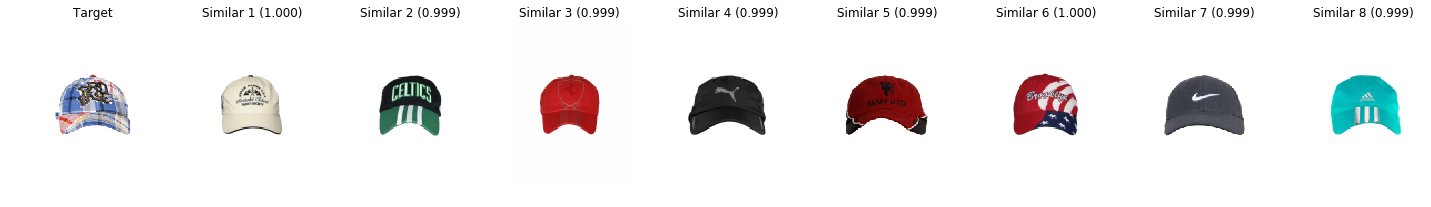

In [10]:
# Importer pandas si ce n'est pas déjà fait
import pandas as pd
from IPython.display import display

# Utilisation du pipeline
target_idx = 573
similar_items, weights, updated_embeddings = run_enhanced_recommendation_pipeline(df_embs, target_idx)

# Affichage des résultats sous forme de tableau
print(f"Articles similaires à l'article {target_idx}:")

# Créer une liste de dictionnaires pour chaque article similaire (sans inclure le target)
similar_articles = []
for idx, (item, weight) in enumerate(zip(similar_items, weights)):
    similar_articles.append({
        "Master Category": df.iloc[item]['masterCategory'],
        "Sub Category": df.iloc[item]['subCategory'],
        "Article Type": df.iloc[item]['articleType'],
        "Product Display Name": df.iloc[item]['productDisplayName'],
        "Similarity Score": round(weight, 4)
    })

# Convertir la liste en DataFrame et l'afficher
similar_articles_df = pd.DataFrame(similar_articles)
display(similar_articles_df)

# Affichage des images
figures = {}
figures["Target"] = load_image(df.iloc[target_idx].image)

for i, similar_idx in enumerate(similar_items):
    figures[f"Similar {i+1} ({weights[i]:.3f})"] = load_image(df.iloc[similar_idx].image)

plot_figures(figures, nrows=1, ncols=len(figures), figsize=(20, 5))

Articles similaires à l'article 2300:


,Master Category,Sub Category,Article Type,Product Display Name,Similarity Score
0,Footwear,Shoes,Formal Shoes,Carlton London Men Black Oxford Wingtip Brogues,0.9947
1,Footwear,Shoes,Formal Shoes,Franco Leone Men Black Formal Shoes,0.9874
2,Footwear,Shoes,Formal Shoes,Lee Cooper Men Black Shoe,0.9647
3,Footwear,Shoes,Formal Shoes,Lee Cooper Men Nnado Black Formal Shoes,0.9741
4,Footwear,Shoes,Formal Shoes,Red Tape Men's Formal Light Brown Shoe,0.9665
5,Footwear,Shoes,Formal Shoes,Cobblerz Men Black Formal Shoes,0.9638
6,Footwear,Shoes,Formal Shoes,Enroute Men Leather Tan Formal Shoes,0.9475
7,Footwear,Shoes,Casual Shoes,Timberland Men Black Casual Shoes,0.9636


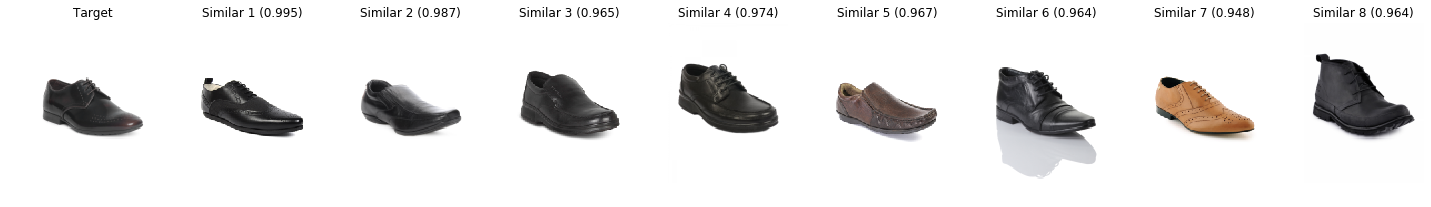

In [11]:
# Utilisation du pipeline
target_idx = 2300
similar_items, weights, updated_embeddings = run_enhanced_recommendation_pipeline(df_embs, target_idx)

# Affichage des résultats sous forme de tableau
print(f"Articles similaires à l'article {target_idx}:")

# Créer une liste de dictionnaires pour chaque article similaire (sans inclure le target)
similar_articles = []
for idx, (item, weight) in enumerate(zip(similar_items, weights)):
    similar_articles.append({
        "Master Category": df.iloc[item]['masterCategory'],
        "Sub Category": df.iloc[item]['subCategory'],
        "Article Type": df.iloc[item]['articleType'],
        "Product Display Name": df.iloc[item]['productDisplayName'],
        "Similarity Score": round(weight, 4)
    })

# Convertir la liste en DataFrame et l'afficher
similar_articles_df = pd.DataFrame(similar_articles)
display(similar_articles_df)

# Affichage des images
figures = {}
figures["Target"] = load_image(df.iloc[target_idx].image)

for i, similar_idx in enumerate(similar_items):
    figures[f"Similar {i+1} ({weights[i]:.3f})"] = load_image(df.iloc[similar_idx].image)

plot_figures(figures, nrows=1, ncols=len(figures), figsize=(20, 5))

## Évaluation de la Performance de System de Recommandation

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings

# Fonction principale pour le calcul des métriques
def calculate_global_metrics_with_additional_metrics(df, df_embs, sample_size=500, top_n=8):
    indices = np.random.choice(len(df), sample_size, replace=False)
    all_true_labels = []
    all_predicted_labels = []
    squared_errors = []

    for idx in indices:
        # Remplacer ceci par votre fonction de recommandation améliorée
        similar_items, weights, _ = run_enhanced_recommendation_pipeline(df_embs, idx, top_n=top_n)
        
        if len(similar_items) == 0:
            continue
        
        true_type = df.iloc[idx]['articleType']
        pred_types = df.iloc[similar_items]['articleType'].values
        true_relevance = np.array([1 if t == true_type else 0 for t in pred_types])
        
        all_true_labels.extend([true_type] * len(similar_items))
        all_predicted_labels.extend(pred_types)
        squared_errors.extend((1 - weights) ** 2)

    # Calcul des métriques
    metrics = {
        'accuracy': sum(1 for t, p in zip(all_true_labels, all_predicted_labels) if t == p) / len(all_true_labels),
        'precision': precision_score(all_true_labels, all_predicted_labels, average='weighted'),
        'recall': recall_score(all_true_labels, all_predicted_labels, average='weighted'),
        'f1_score': f1_score(all_true_labels, all_predicted_labels, average='weighted'),
        'rmse': np.sqrt(np.mean(squared_errors)),
    }
    
    return metrics

In [72]:
# Ignorer les warnings
warnings.filterwarnings('ignore')

# Fonction d'affichage des métriques
def print_metrics(metrics):
    print("\nGlobal Evaluation Metrics:")
    print("-" * 50)
    for metric, value in metrics.items():
        if metric != 'rmse':
            print(f"{metric.title():9}: {value*100:>8.2f}%")
        else:
            print(f"{metric.upper():9}: {value:>8.4f}")


metrics = calculate_global_metrics_with_additional_metrics(df, df_embs, sample_size= 500)

# Affichage des résultats
print_metrics(metrics)


Global Evaluation Metrics:
--------------------------------------------------
Accuracy :    88.00%
Precision:    88.50%
Recall   :    88.00%
F1_Score :    87.84%
RMSE     :   0.0339


# Autres similarités pour faire une comparaison

# Similarité Cosinus (Cosine Similarity)

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Construire le graphe basé sur les similarités entre les embeddings
def build_graph_cos(df_embs, threshold=0.85):
    """
    Construction du graphe avec sélection des k voisins les plus proches (basé sur cosine similarity)
    """
    G = nx.Graph()
    num_items = len(df_embs)
    similarities = cosine_similarity(df_embs)
    
    for i in range(num_items):
        G.add_node(i)
        # Sélectionner les 10 voisins les plus similaires
        top_k_neighbors = np.argsort(similarities[i])[::-1][1:11]
        
        for j in top_k_neighbors:
            if similarities[i, j] > threshold:
                G.add_edge(i, j, weight=similarities[i, j])
    
    return G
    
# 2. Calculer les poids d'attention pour les voisins dans le graphe
def compute_attention_cos(graph, embeddings):
    """
    Calcule les poids d'attention (cosine) pour chaque voisin d'un nœud dans le graphe.
    """
    attention_weights_cos = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
        node_embedding = embeddings[node].reshape(1, -1)
        neighbor_embeddings = embeddings[neighbors]
        similarities = cosine_similarity(node_embedding, neighbor_embeddings).flatten()
        exp_similarities = np.exp(similarities)
        attention_weights_cos[node] = exp_similarities / np.sum(exp_similarities)
    return attention_weights_cos

# 3. Propagation des informations à travers le graphe
def propagate_information_cos(graph, embeddings, attention_weights_cos, num_iterations=4):
    updated_embeddings_cos = embeddings.copy()
    for _ in range(num_iterations):
        new_embeddings_cos = updated_embeddings_cos.copy()
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue
            
            # Add a normalization factor
            aggregated = np.zeros_like(embeddings[node])
            total_weight = 0
            
            for i, neighbor in enumerate(neighbors):
                weight = attention_weights_cos[node][i]
                aggregated += weight * updated_embeddings_cos[neighbor]
                total_weight += weight
            
            # Normalize the aggregation
            new_embeddings_cos[node] = aggregated / total_weight if total_weight > 0 else embeddings[node]
        
        updated_embeddings_cos = new_embeddings_cos
    return updated_embeddings_cos

# 4. Recommandation : Trouver les articles les plus similaires
def find_top_similar_items_cos(target_idx, embeddings, top_n=10):
    """
    Trouve les top_n articles les plus similaires à un article cible (basé sur cosine similarity) et calcule leurs poids.
    """
    similarities = cosine_similarity(embeddings[target_idx].reshape(1, -1), embeddings).flatten()
    similar_indices = np.argsort(similarities)[::-1]  # Tri décroissant
    similar_indices = [idx for idx in similar_indices if idx != target_idx]  # Exclure l'article cible
    similar_items = similar_indices[:top_n]
    weights = similarities[similar_items]
    return similar_items, weights

# Pipeline intégré
# Construire le graphe (cosine)
graph_cos = build_graph_cos(df_embs.values, threshold=0.85)

# Calculer les poids d'attention (cosine)
attention_weights_cos = compute_attention_cos(graph_cos, df_embs.values)

# Propager les informations dans le graphe (cosine)
updated_embeddings_cos = propagate_information_cos(graph_cos, df_embs.values, attention_weights_cos, num_iterations=4)

In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings

def run_recommendation_pipeline_cos(df_embs, target_idx, top_n=10):
    """
    Pipeline complet pour la version cosinus
    """
    # Construction du graphe
    graph = build_graph_cos(df_embs.values, threshold=0.85)
    
    # Calcul des poids d'attention
    attention_weights = compute_attention_cos(graph, df_embs.values)
    
    # Propagation d'information
    updated_embeddings = propagate_information_cos(
        graph, 
        df_embs.values, 
        attention_weights, 
        num_iterations=4
    )
    
    # Recherche des articles similaires
    similar_items, weights = find_top_similar_items_cos(
        target_idx, 
        updated_embeddings, 
        top_n=top_n
    )
    
    return similar_items, weights, updated_embeddings

def calculate_global_metrics_cos(df, df_embs, sample_size=500, top_n=10):
    """
    Calcul des métriques globales pour la version cosinus
    """
    indices = np.random.choice(len(df), sample_size, replace=False)
    all_true_labels = []
    all_predicted_labels = []
    squared_errors = []
    
    for idx in indices:
        similar_items, weights, updated_embeddings = run_recommendation_pipeline_cos(
            df_embs, 
            idx, 
            top_n=top_n
        )
        
        if len(similar_items) == 0:
            continue
            
        # Calcul des métriques de classification
        true_type = df.iloc[idx]['articleType']
        pred_types = df.iloc[similar_items]['articleType'].values
        true_relevance = np.array([1 if t == true_type else 0 for t in pred_types])
        
        all_true_labels.extend([true_type] * len(similar_items))
        all_predicted_labels.extend(pred_types)
        
        # Calcul des métriques de ranking
        squared_errors.extend((1 - weights) ** 2)
    
    # Compilation des métriques
    metrics = {
        'accuracy': sum(1 for t, p in zip(all_true_labels, all_predicted_labels) if t == p) / len(all_true_labels),
        'precision': precision_score(all_true_labels, all_predicted_labels, average='weighted'),
        'recall': recall_score(all_true_labels, all_predicted_labels, average='weighted'),
        'f1_score': f1_score(all_true_labels, all_predicted_labels, average='weighted'),
        'rmse': np.sqrt(np.mean(squared_errors))
    }
    
    return metrics

In [79]:
def print_metrics_cos(metrics):
    """
    Affichage formaté des métriques pour la version cosinus
    """
    print("\nGlobal Evaluation Metrics (Cosine-based):")
    print("-" * 50)
    for metric, value in metrics.items():
        if metric != 'rmse':
            print(f"{metric.title():9}: {value*100:>8.2f}%")
        else:
            print(f"{metric.upper():9}: {value:>8.4f}")

# Calcul des métriques
metrics_cos = calculate_global_metrics_cos(df, df_embs, sample_size= 500, top_n=8)

# Affichage des résultats
print_metrics_cos(metrics_cos)


Global Evaluation Metrics (Cosine-based):
--------------------------------------------------
Accuracy :    82.88%
Precision:    84.11%
Recall   :    82.88%
F1_Score :    83.04%
RMSE     :   0.0828


# Similarité Euclidienne (Euclidean Similarity)

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import euclidean

def build_graph_euclidean(df_embs, threshold=2.0):
    """
    Build graph based on Euclidean distance between embeddings
    """
    G = nx.Graph()
    num_items = len(df_embs)
    
    for i in range(num_items):
        G.add_node(i)
        distances = np.array([euclidean(df_embs[i], df_embs[j]) for j in range(num_items)])
        top_k_neighbors = np.argsort(distances)[1:11]
        
        for j in top_k_neighbors:
            if distances[j] < threshold:
                G.add_edge(i, j, weight=1/(distances[j] + 1e-6))
    
    return G

def compute_attention_euclidean(graph, embeddings):
    """
    Compute attention weights using Euclidean distance
    """
    attention_weights = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
        
        distances = np.array([euclidean(embeddings[node], embeddings[n]) for n in neighbors])
        inv_distances = 1 / (distances + 1e-6)
        attention_weights[node] = inv_distances / np.sum(inv_distances)
    
    return attention_weights

def propagate_information_euclidean(graph, embeddings, attention_weights, num_iterations=4):
    """
    Propagate information through graph using Euclidean distance
    """
    updated_embeddings = embeddings.copy()
    
    for _ in range(num_iterations):
        new_embeddings = updated_embeddings.copy()
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue
            
            aggregated = np.zeros_like(embeddings[node])
            total_weight = 0
            
            for i, neighbor in enumerate(neighbors):
                weight = attention_weights[node][i]
                aggregated += weight * updated_embeddings[neighbor]
                total_weight += weight
            
            new_embeddings[node] = aggregated / total_weight if total_weight > 0 else embeddings[node]
        
        updated_embeddings = new_embeddings
    
    return updated_embeddings

def find_top_similar_items_euclidean(target_idx, embeddings, top_n=10):
    """
    Find top_n most similar items based on Euclidean distance
    """
    distances = np.array([euclidean(embeddings[target_idx], emb) for emb in embeddings])
    similar_indices = np.argsort(distances)
    similar_indices = [idx for idx in similar_indices if idx != target_idx]
    similar_items = similar_indices[:top_n]
    weights = 1 / (distances[similar_items] + 1e-6)
    weights = weights / np.sum(weights)  # Normalize weights
    return similar_items, weights

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from concurrent.futures import ThreadPoolExecutor
import warnings

def run_recommendation_pipeline_euclidean(df_embs, target_idx, top_n=8):
    """
    Pipeline pour la version euclidean
    """
    # Vectorisation des calculs avec NumPy
    embeddings = df_embs.values
    
    # Construction du graphe
    distances = np.linalg.norm(embeddings - embeddings[target_idx], axis=1)
    graph = distances <= 2.0
    
    # Calcul des poids d'attention vectorisé
    attention_weights = np.exp(-distances[graph])
    attention_weights /= np.sum(attention_weights)
    
    # Propagation d'information
    updated_embeddings = embeddings.copy()
    for _ in range(4):
        weighted_sum = np.zeros_like(embeddings)
        np.add.at(weighted_sum, graph.nonzero()[0], 
                 embeddings[graph] * attention_weights[:, np.newaxis])
        updated_embeddings = weighted_sum / np.sum(graph)
    
    # Recherche des articles similaires
    similarities = -np.linalg.norm(updated_embeddings - updated_embeddings[target_idx], axis=1)
    top_indices = np.argpartition(similarities, -(top_n+1))[-(top_n+1):]
    top_indices = top_indices[top_indices != target_idx][:top_n]
    weights = 1 / (1 + np.exp(-similarities[top_indices]))
    
    return top_indices, weights, updated_embeddings

def process_single_item(args):
    """
    Fonction helper pour le traitement parallèle
    """
    idx, df, df_embs, top_n = args
    similar_items, weights, _ = run_recommendation_pipeline_euclidean(df_embs, idx, top_n)
    
    if len(similar_items) == 0:
        return None
        
    true_type = df.iloc[idx]['articleType']
    pred_types = df.iloc[similar_items]['articleType'].values
    true_relevance = np.array([1 if t == true_type else 0 for t in pred_types])
    
    return {
        'true_labels': [true_type] * len(similar_items),
        'pred_labels': pred_types.tolist(),
        'squared_errors': ((1 - weights) ** 2).tolist()
    }

def calculate_global_metrics_euclidean(df, df_embs, sample_size=500, top_n=8):
    """
    Calcul parallélisé des métriques globales
    """
    indices = np.random.choice(len(df), sample_size, replace=False)
    args_list = [(idx, df, df_embs, top_n) for idx in indices]
    
    all_results = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = executor.map(process_single_item, args_list)
        all_results = [r for r in results if r is not None]
    
    # Agrégation des résultats
    all_true_labels = sum((r['true_labels'] for r in all_results), [])
    all_predicted_labels = sum((r['pred_labels'] for r in all_results), [])
    squared_errors = sum((r['squared_errors'] for r in all_results), [])
    
    metrics = {
        'accuracy': sum(1 for t, p in zip(all_true_labels, all_predicted_labels) if t == p) / len(all_true_labels),
        'precision': precision_score(all_true_labels, all_predicted_labels, average='weighted'),
        'recall': recall_score(all_true_labels, all_predicted_labels, average='weighted'),
        'f1_score': f1_score(all_true_labels, all_predicted_labels, average='weighted'),
        'rmse': np.sqrt(np.mean(squared_errors))
    }
    
    return metrics

In [23]:
def print_metrics_euclidean(metrics):
    """
    Affichage formaté des métriques
    """
    print("\nGlobal Evaluation Metrics (Euclidean-based):")
    print("-" * 50)
    for metric, value in metrics.items():
        if metric != 'rmse':
            print(f"{metric.title():9}: {value*100:>8.2f}%")
        else:
            print(f"{metric.upper():9}: {value:>8.4f}")
            
# Calcul des métriques
metrics_euclidean = calculate_global_metrics_euclidean(df, df_embs, sample_size= 500, top_n=8)

# Affichage des résultats
print_metrics_euclidean(metrics_euclidean)


Global Evaluation Metrics (Euclidean-based):
--------------------------------------------------
Accuracy :    82.12%
Precision:    82.36%
Recall   :    82.12%
F1_Score :    81.63%
RMSE     :   0.5000


# Similarité de Manhattan (Manhattan Similarity)

In [34]:
from sklearn.metrics.pairwise import manhattan_distances
import torch
import torch.nn.functional as F
import torch.nn as nn
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

def manhattan_similarity(X, Y=None):
    """
    Convert Manhattan distance to similarity score.
    Returns values between 0 and 1, where 1 means identical vectors.
    
    Parameters:
    X : array-like of shape (n_samples_X, n_features)
    Y : array-like of shape (n_samples_Y, n_features), optional
    """
    distances = manhattan_distances(X, Y)
    # Normalize distances to [0, 1] range and convert to similarities
    scaler = MinMaxScaler()
    normalized_distances = scaler.fit_transform(distances.reshape(-1, 1)).reshape(distances.shape)
    similarities = 1 - normalized_distances
    return similarities

def build_graph(df_embs, threshold=0.7):
    """
    Construction du graphe avec sélection des k voisins les plus proches
    utilisant la similarité basée sur la distance de Manhattan
    """
    G = nx.Graph()
    num_items = len(df_embs)
    similarities = manhattan_similarity(df_embs)
    
    for i in range(num_items):
        G.add_node(i)
        # Sélectionner les 10 voisins les plus similaires
        top_k_neighbors = np.argsort(similarities[i])[::-1][1:11]
        
        for j in top_k_neighbors:
            if similarities[i, j] > threshold:
                G.add_edge(i, j, weight=similarities[i, j])
    
    return G

def compute_attention(graph, embeddings):
    """
    Calcule les poids d'attention pour chaque voisin d'un nœud dans le graphe
    en utilisant la similarité basée sur la distance de Manhattan.
    """
    attention_weights = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
        
        node_embedding = embeddings[node].reshape(1, -1)
        neighbor_embeddings = embeddings[neighbors]
        similarities = manhattan_similarity(node_embedding, neighbor_embeddings).flatten()
        exp_similarities = np.exp(similarities)
        attention_weights[node] = exp_similarities / np.sum(exp_similarities)
    
    return attention_weights

def propagate_information(graph, embeddings, attention_weights, num_iterations=4):
    """
    Propagation des informations à travers le graphe
    La fonction reste la même car elle utilise les poids d'attention déjà calculés
    """
    updated_embeddings = embeddings.copy()
    for _ in range(num_iterations):
        new_embeddings = updated_embeddings.copy()
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue
            
            aggregated = np.zeros_like(embeddings[node])
            total_weight = 0
            
            for i, neighbor in enumerate(neighbors):
                weight = attention_weights[node][i]
                aggregated += weight * updated_embeddings[neighbor]
                total_weight += weight
            
            new_embeddings[node] = aggregated / total_weight if total_weight > 0 else embeddings[node]
        
        updated_embeddings = new_embeddings
    return updated_embeddings

def find_top_similar_items(target_idx, embeddings, top_n=10):
    """
    Trouve les top_n articles les plus similaires à un article cible
    en utilisant la similarité basée sur la distance de Manhattan
    """
    similarities = manhattan_similarity(
        embeddings[target_idx].reshape(1, -1), 
        embeddings
    ).flatten()
    
    similar_indices = np.argsort(similarities)[::-1]
    similar_indices = [idx for idx in similar_indices if idx != target_idx]
    similar_items = similar_indices[:top_n]
    weights = similarities[similar_items]
    return similar_items, weights

# Pipeline intégré
# Construire le graphe
graph = build_graph(df_embs.values, threshold=0.7)
# Calculer les poids d'attention
attention_weights = compute_attention(graph, df_embs.values)
# Propager les informations dans le graphe
updated_embeddings = propagate_information(graph, df_embs.values, attention_weights, num_iterations=4)

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings

def run_recommendation_pipeline_man(df_embs, target_idx, top_n=10):
    """
    Pipeline complet pour la version manhattan
    """
    # Construction du graphe
    graph = build_graph(df_embs.values, threshold=0.85)
    
    # Calcul des poids d'attention
    attention_weights = compute_attention(graph, df_embs.values)
    
    # Propagation d'information
    updated_embeddings = propagate_information(
        graph, 
        df_embs.values, 
        attention_weights, 
        num_iterations=4
    )
    
    # Recherche des articles similaires
    similar_items, weights = find_top_similar_items(
        target_idx, 
        updated_embeddings, 
        top_n=top_n
    )
    
    return similar_items, weights, updated_embeddings

def calculate_global_metrics(df, df_embs, sample_size=500, top_n=10):
    """
    Calcul des métriques globales pour la version manhattan
    """
    indices = np.random.choice(len(df), sample_size, replace=False)
    all_true_labels = []
    all_predicted_labels = []
    squared_errors = []
    
    for idx in indices:
        similar_items, weights, updated_embeddings = run_recommendation_pipeline_man(
            df_embs, 
            idx, 
            top_n=top_n
        )
        
        if len(similar_items) == 0:
            continue
            
        # Calcul des métriques de classification
        true_type = df.iloc[idx]['articleType']
        pred_types = df.iloc[similar_items]['articleType'].values
        true_relevance = np.array([1 if t == true_type else 0 for t in pred_types])
        
        all_true_labels.extend([true_type] * len(similar_items))
        all_predicted_labels.extend(pred_types)
        
        # Calcul des métriques de ranking
        squared_errors.extend((1 - weights) ** 2)
    
    # Compilation des métriques
    metrics = {
        'accuracy': sum(1 for t, p in zip(all_true_labels, all_predicted_labels) if t == p) / len(all_true_labels),
        'precision': precision_score(all_true_labels, all_predicted_labels, average='weighted'),
        'recall': recall_score(all_true_labels, all_predicted_labels, average='weighted'),
        'f1_score': f1_score(all_true_labels, all_predicted_labels, average='weighted'),
        'rmse': np.sqrt(np.mean(squared_errors))
    }
    
    return metrics

In [36]:
def print_metrics_man(metrics):
    """
    Affichage formaté des métriques pour la version manhattan
    """
    print("\nGlobal Evaluation Metrics (Manhttan-based):")
    print("-" * 50)
    for metric, value in metrics.items():
        if metric != 'rmse':
            print(f"{metric.title():9}: {value*100:>8.2f}%")
        else:
            print(f"{metric.upper():9}: {value:>8.4f}")

# Calcul des métriques
metrics_man = calculate_global_metrics(df, df_embs, sample_size=500, top_n=8)

# Affichage des résultats
print_metrics_man(metrics_man)


Global Evaluation Metrics (Manhttan-based):
--------------------------------------------------
Accuracy :    84.42%
Precision:    85.25%
Recall   :    84.42%
F1_Score :    84.33%
RMSE     :   0.1337


# Visualisation de la comparaison des similarités

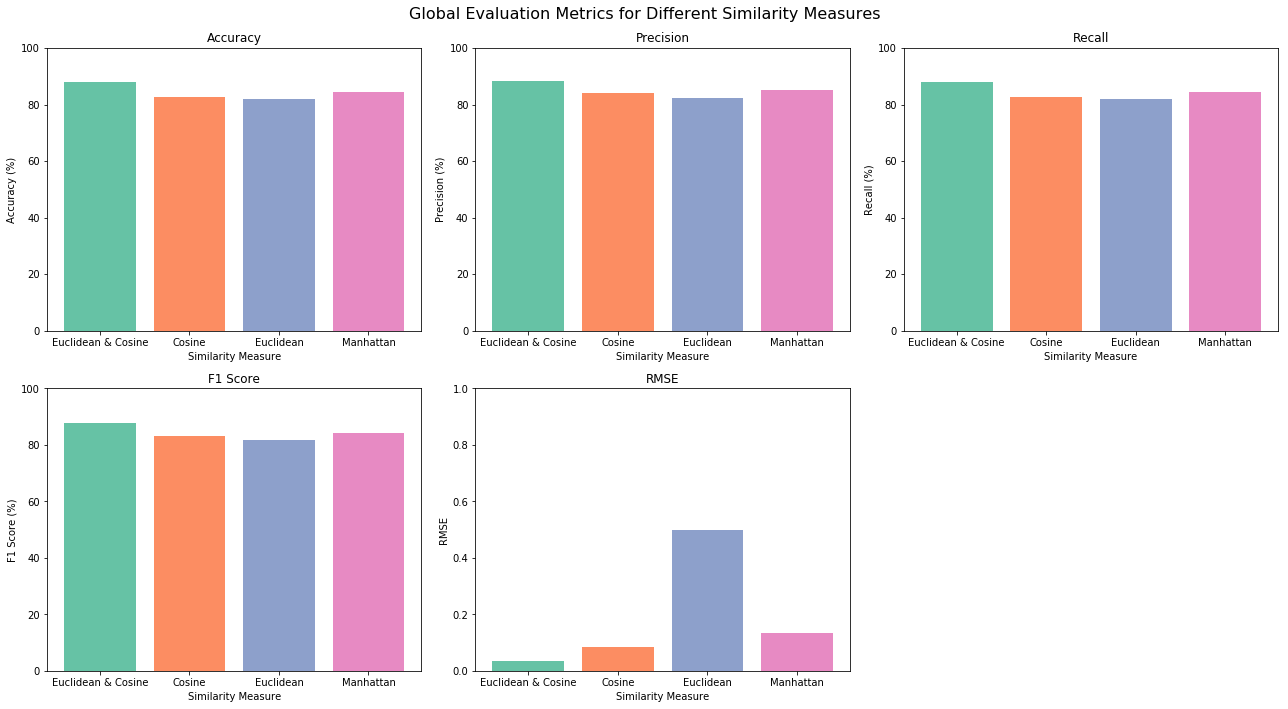

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data
similarities = ['Euclidean & Cosine', 'Cosine', 'Euclidean', 'Manhattan']
metrics = {
    'Accuracy': [88.00, 82.88, 82.12, 84.42],
    'Precision': [88.50, 84.11, 82.36, 85.25],
    'Recall': [88.00, 82.88, 82.12, 84.42],
    'F1 Score': [87.84, 83.04, 81.63, 84.33],
    'RMSE': [0.0339, 0.0828, 0.5000, 0.1337],
}

# Convert to numpy array for easy indexing
metrics_array = np.array(list(metrics.values()))
metric_names = list(metrics.keys())

# Create a plot with 2x3 grid but only use 5 subplots
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1]))

fig.suptitle('Global Evaluation Metrics for Different Similarity Measures', fontsize=16)

# Plot each metric
for i, ax in enumerate(axes):
    ax.bar(similarities, metrics_array[i], color=sns.color_palette("Set2", len(similarities)))
    ax.set_title(metric_names[i])
    ax.set_xlabel('Similarity Measure')
    
    if metric_names[i] != 'RMSE':  # For metrics other than RMSE
        ax.set_ylim(0, 100)  # Adjust Y axis for better visualization
        ax.set_ylabel(f'{metric_names[i]} (%)')
    else:  # For RMSE
        ax.set_ylim(0, 1.0)  # RMSE should be between 0 and 1
        ax.set_ylabel('RMSE')

# Adjust layout to avoid overlapping titles/labels
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualisation de l'Espace Latent des Contenus

Puisque notre espace latent n'est pas à deux dimensions, nous allons utiliser t-SNE (t-distributed Stochastic Neighbor Embedding) pour réduire la dimensionnalité, afin de permettre des visualisations intéressantes à ce stade. L'une des visualisations possibles est d'observer les voisinages de différentes classes dans le plan latent 2D.

In [7]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [8]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [9]:
EMBS_PATH = "/kaggle/input/finaldataset/"
# Load pre-computed embeddings
df_embs = pd.read_csv(EMBS_PATH + "embeddings.csv")
df_embs = df_embs.iloc[:, 1:]  # Remove index column if present
df_embs

,1,2,3,4,5,6,7,8,9,10,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.366158,0.000000,3.255738,0.845206,2.673840,8.780885,6.280785,0.787186,1.587662,4.747005,...,2.463607,0.000000,1.825990,20.485271,3.902871,0.000000,8.225971,1.313863,0.000000,10.820534
1,9.593652,0.000000,9.431687,0.287238,0.259950,17.028755,3.037456,0.136339,0.000000,1.965363,...,1.670569,0.013894,10.338678,4.784732,0.189142,0.000000,7.739138,0.372693,0.000000,8.903797
2,3.162264,0.484694,0.172313,2.609545,3.840852,3.426132,0.253247,1.098901,1.418278,4.961284,...,0.434923,14.092848,3.018758,2.134510,2.549057,0.377387,6.180353,0.636621,14.018168,11.415053
3,1.958622,0.000000,12.519884,0.000000,0.000000,9.383584,3.781623,0.000000,1.490620,1.974221,...,17.825481,0.000000,3.592511,2.042306,0.000000,0.000000,6.656784,1.457313,1.694215,1.403331
4,17.383436,0.493822,3.374463,2.567366,0.000000,6.482548,5.862635,0.000000,3.164864,2.575928,...,4.464021,0.447082,1.448132,12.884141,0.000000,0.397488,5.028076,1.939697,0.000000,11.485396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,1.086933,10.603666,0.000000,0.899589,4.906456,4.040016,3.416561,0.000000,0.000000,13.161461,...,0.000000,0.000000,7.320971,0.000000,9.822886,4.144007,6.952935,0.000000,0.020810,4.872601
44420,0.745805,2.542379,4.390184,0.557589,8.990882,23.827869,0.624198,0.000000,2.196723,16.549940,...,16.779911,5.880525,5.349078,0.000000,1.521402,9.757891,8.682236,8.933413,3.940487,3.360285
44421,17.258789,1.072109,2.708099,0.259384,0.000000,4.596123,4.987752,3.391690,0.304968,0.000000,...,5.246232,2.968144,1.390609,18.857891,0.000000,0.000000,3.451751,5.321138,0.000000,13.287771
44422,0.416820,0.440426,0.014159,12.214248,3.102999,1.316717,1.407639,0.000000,0.000000,1.542082,...,2.067938,8.295972,3.333411,2.257573,3.544628,0.000000,4.615053,4.111631,11.224733,5.817847


In [75]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 14.882241487503052 seconds


In [11]:
from sklearn.preprocessing import StandardScaler

# Optionally, you can fill NaN values with a specific value (e.g., zero or mean)
df_embs_clean = df_embs.replace([np.inf, -np.inf], np.nan).fillna(0)

# Alternatively, scale the data if necessary
scaler = StandardScaler()
df_embs_clean = scaler.fit_transform(df_embs_clean)

In [ ]:
# Apply t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs_clean)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [76]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

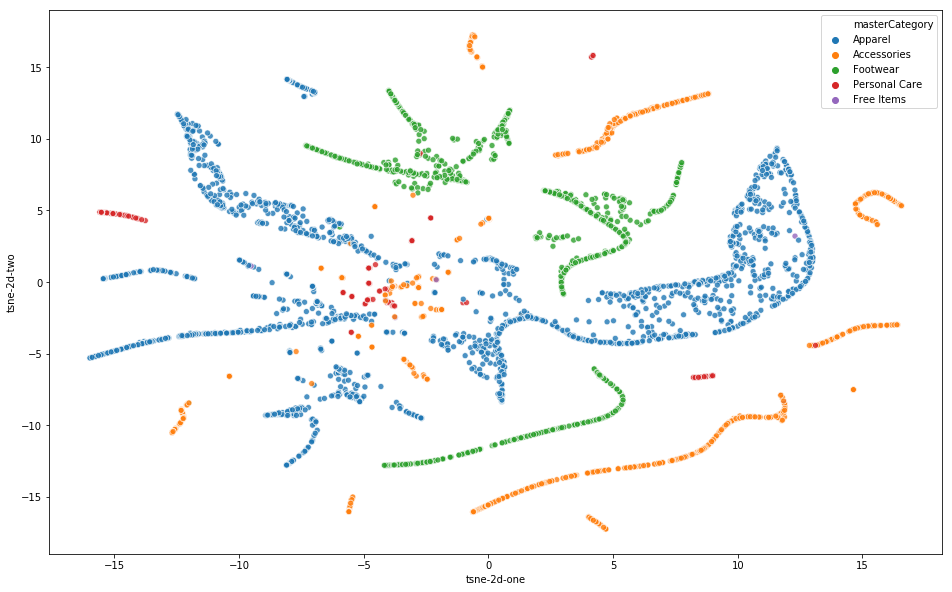

In [80]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

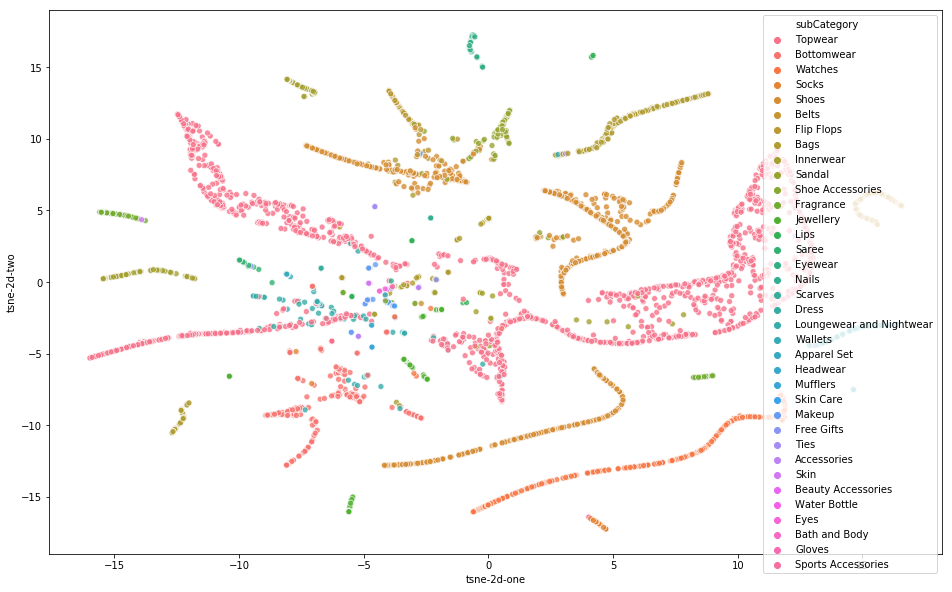

In [78]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

# Autres Modéles pour Comparaison

# AlexNet

In [58]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Fonction pour construire AlexNet
def create_alexnet(input_shape=(299, 299, 3)):
    input_layer = Input(shape=input_shape)
    x = Conv2D(96, (11, 11), strides=4, activation='relu', name='conv1')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, name='pool1')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name='conv2')(x)
    x = MaxPooling2D((3, 3), strides=2, name='pool2')(x)
    x = Conv2D(384, (3, 3), padding='same', activation='relu', name='conv3')(x)
    x = Conv2D(384, (3, 3), padding='same', activation='relu', name='conv4')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv5')(x)
    x = MaxPooling2D((3, 3), strides=2, name='pool5')(x)
    x = GlobalMaxPooling2D()(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

# Créer le modèle
alexnet_model = create_alexnet()
alexnet_model.trainable = False

In [74]:
def safe_get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except FileNotFoundError:
        print(f"File not found: {img_path(img_name)}")
        return None  # Return None for missing files

# Apply the function to the dataset
df['embedding'] = df['image'].apply(lambda img: safe_get_embedding(alexnet_model, img))

File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39403.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39410.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39401.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39425.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/12347.jpg


In [77]:
df = df.dropna(subset=['embedding'])  # Supprimer les lignes sans embeddings

# Extraire les features et les labels
X = np.array(df['embedding'].tolist())
y = df['articleType']

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Nombre de classes
num_classes = len(label_encoder.classes_)

In [78]:
# Fonction pour créer un classifieur
def create_classifier(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(2048, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Initialisation du modèle
classifier = create_classifier(X_train.shape[1], len(label_encoder.classes_))

# Compilation
classifier.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Entraînement
history = classifier.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Train on 28428 samples, validate on 7107 samples
Epoch 1/100
28428/28428 [==============================] - 4s 136us/sample - loss: 18.5967 - acc: 0.1751 - val_loss: 13.2611 - val_acc: 0.2699
Epoch 2/100
28428/28428 [==============================] - 3s 99us/sample - loss: 10.7816 - acc: 0.3166 - val_loss: 8.4186 - val_acc: 0.4406
Epoch 3/100
28428/28428 [==============================] - 3s 99us/sample - loss: 7.1249 - acc: 0.4010 - val_loss: 5.7168 - val_acc: 0.4694
Epoch 4/100
28428/28428 [==============================] - 3s 99us/sample - loss: 5.0666 - acc: 0.4428 - val_loss: 4.2835 - val_acc: 0.5005
Epoch 5/100
28428/28428 [==============================] - 3s 100us/sample - loss: 3.9403 - acc: 0.4665 - val_loss: 3.4546 - val_acc: 0.5189
Epoch 6/100
28428/28428 [==============================] - 3s 105us/sample - loss: 3.3252 - acc: 0.4779 - val_loss: 3.0685 - val_acc: 0.5109
Epoch 7/100
28428/28428 [==============================] - 3s 100us/sample - loss: 2.9757 - acc: 0.4941 -

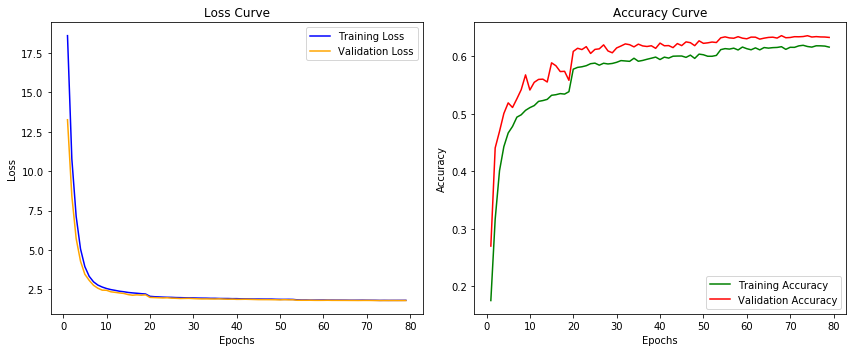

In [83]:
# Tracer les courbes d'apprentissage
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['acc'], label='Training Accuracy', color='green')
    plt.plot(epochs, history.history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction
plot_learning_curves(history)

In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ignorer les warnings
warnings.filterwarnings('ignore')

# Prédictions sur l'ensemble de test
y_pred = np.argmax(classifier.predict(X_test), axis=1)

# Calcul des métriques globales
precision = precision_score(y_test, y_pred, average='weighted')  # Précision pondérée
recall = recall_score(y_test, y_pred, average='weighted')        # Rappel pondéré
f1 = f1_score(y_test, y_pred, average='weighted')                # F1-score pondéré

# Afficher les métriques globales
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.5821
Recall: 0.6317
F1-score: 0.5913


In [79]:
# Évaluation sur le jeu de test
test_loss, test_accuracy = classifier.evaluate(X_test, y_test)
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

8884/8884 [==============================] - 0s 47us/sample - loss: 1.7872 - acc: 0.6317
Loss: 1.7872, Accuracy: 0.6317


# GoogleNet

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import cv2

# Load InceptionV3 (GoogleNet) model for feature extraction
def create_googlenet(input_shape=(299, 299, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
    base_model.trainable = False
    return base_model

# Initialize GoogleNet model
googlenet_model = create_googlenet()

87916544/87910968 [==============================] - 2s 0us/step


In [6]:
def safe_get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except FileNotFoundError:
        print(f"File not found: {img_path(img_name)}")
        return None  # Return None for missing files

# Apply the function to the dataset
df['embedding'] = df['image'].apply(lambda img: safe_get_embedding(googlenet_model, img))

File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39403.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39410.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39401.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/39425.jpg
File not found: /kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset//images/12347.jpg


In [7]:
# Remove rows without embeddings
df = df.dropna(subset=['embedding'])

# Extract features and labels
X = np.array(df['embedding'].tolist())
y = df['articleType']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Number of classes
num_classes = len(label_encoder.classes_)

In [8]:
# Function to create a classifier
def create_classifier(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(2048, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize classifier
classifier = create_classifier(X_train.shape[1], num_classes)

# Compile the model
classifier.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train the model
history = classifier.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Train on 28428 samples, validate on 7107 samples
Epoch 1/100
28428/28428 [==============================] - 5s 176us/sample - loss: 19.1589 - acc: 0.6284 - val_loss: 8.1825 - val_acc: 0.7260
Epoch 2/100
28428/28428 [==============================] - 3s 119us/sample - loss: 5.2863 - acc: 0.7171 - val_loss: 3.4195 - val_acc: 0.7350
Epoch 3/100
28428/28428 [==============================] - 3s 121us/sample - loss: 2.7385 - acc: 0.7267 - val_loss: 2.1944 - val_acc: 0.7404
Epoch 4/100
28428/28428 [==============================] - 3s 118us/sample - loss: 1.9916 - acc: 0.7290 - val_loss: 1.7711 - val_acc: 0.7426
Epoch 5/100
28428/28428 [==============================] - 3s 116us/sample - loss: 1.7026 - acc: 0.7348 - val_loss: 1.6081 - val_acc: 0.7405
Epoch 6/100
28428/28428 [==============================] - 3s 116us/sample - loss: 1.5705 - acc: 0.7377 - val_loss: 1.4965 - val_acc: 0.7508
Epoch 7/100
28428/28428 [==============================] - 3s 117us/sample - loss: 1.5002 - acc: 0.7399 

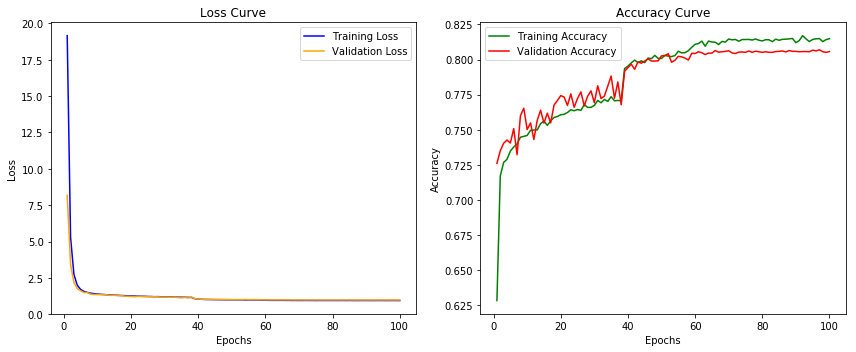

In [9]:
# Tracer les courbes d'apprentissage
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['acc'], label='Training Accuracy', color='green')
    plt.plot(epochs, history.history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction
plot_learning_curves(history)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ignorer les warnings
warnings.filterwarnings('ignore')

# Prédictions sur l'ensemble de test
y_pred = np.argmax(classifier.predict(X_test), axis=1)

# Calcul des métriques globales
precision = precision_score(y_test, y_pred, average='weighted')  # Précision pondérée
recall = recall_score(y_test, y_pred, average='weighted')        # Rappel pondéré
f1 = f1_score(y_test, y_pred, average='weighted')                # F1-score pondéré

# Afficher les métriques globales
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.7783
Recall: 0.8125
F1-score: 0.7872


In [11]:
# Évaluation sur le jeu de test
test_loss, test_accuracy = classifier.evaluate(X_test, y_test)
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

8884/8884 [==============================] - 0s 50us/sample - loss: 0.9511 - acc: 0.8125
Loss: 0.9511, Accuracy: 0.8125
